# Machine Learning (with `jax`)

In [1]:
import jax
import jax.numpy as np
import jax.lax as lax

In [2]:
import numpy as np0
from functools import partial

In [3]:
# configure matplotlib output
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
col = mpl.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

In [4]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [5]:
# some warnings can get annoying
import warnings
warnings.filterwarnings('ignore')

## Helpful Tools

First let's define some tools that will be useful as we go. Generally, our parameters will be stored in a `jax` tree, which is often just a one level dictionary. Operations don't automatically broadcast across the leaves of a tree, so we need to use `jax.tree_map` to do so. Here's a function that applies a gradient update to a tree

In [6]:
def update_coeff(x, dx, Δ=1):
    return jax.tree_map(lambda a, b: a + Δ*b, x, dx)

## Linear Regression

Here we're considering the case of a linear model with Guassian noise. In this case, the likelihood function looks like

$$
\log(\mathcal{L}) = -\frac{N}{2}\log(2\pi)-N\log(\sigma)-\sum_i \frac{1}{2}\left(\frac{y_i-\beta x_i}{\sigma}\right)^2
$$

For our purposes, it is sufficient to simply maximize the sum (or mean) of the squared errors. We can back out $\sigma$ later on if we want. First let's just use pure `numpy` to generate some random data. No need to mess around with the `jax.random` system here.

In [7]:
# generate random data
N = 10000
β0t, β1t, σ = 3.0, 2.0, 0.5
dat_x = np0.random.randn(N)
dat_y = β0t + β1t*dat_x + σ*np0.random.randn(N)

Now we'll make a function to evaluate the mean squared error (MSE) and compute its derivative function. Then we create an "update" function that uses the gradient to generate a new and hopefully better guess for the coefficients. Notice how we use `jax.jit` as a decorator to automatically compile the update function.

In [8]:
# make a function that evaluates model fit and computes the MSE
def regress_objective(c, x, y):
    β0, β1 = c['β0'], c['β1']
    yhat = β0 + β1*x
    like = -(yhat-y)**2
    return np.mean(like)
d_regress_objective = jax.value_and_grad(regress_objective)

In [9]:
# make a function that updates coefficients
@jax.jit
def regress_update(c, t):
    val, dc = d_regress_objective(c, dat_x, dat_y)
    c1 = update_coeff(c, dc, 0.01)
    ret = {'coeff': c1, 'mse': -val}
    return c1, ret

Finally, we run this through scan and plot the resulting path of coefficients and the MSE. We use a fixed-length loop for simplicity here, but one could also use `lax.while_loop` to exit conditional on the MSE not changing enough over time.  But you wan't to be careful not to exit too early, as sometimes you can get stuck on a flat then suddenly start improving again.

In [10]:
# run the update a fixed number of times
c0 = {'β0': 2.0, 'β1': 1.0}
c1, hist = lax.scan(regress_update, c0, np.arange(500))

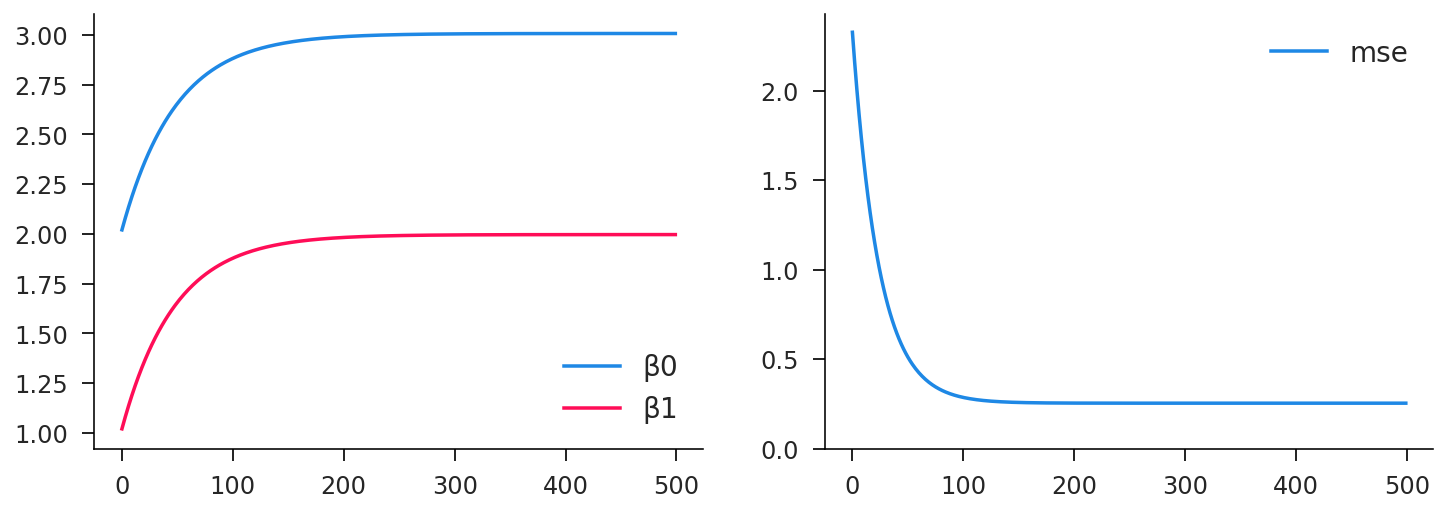

In [11]:
df = pd.DataFrame({**hist['coeff'], 'mse': hist['mse']})
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4))
df[['β0', 'β1']].plot(ax=ax0); df[['mse']].plot(ax=ax1, ylim=(0, None));

## Logistic Regression

Not let's level up to a logistic classification problem. This will ultimately be a stepping stone to multi-layer neural networks. Here were going to define a general logistic learning function and then apply it to various types of data. Our likelihood (and objective function) in this case is

$$
\log(\mathcal{L}) = \sum_i y_i \log(p_i) + (1-y_i) \log(1-p_i)
$$

where $x_i \in \{0,1\}$ and $p_i$ is the predicted probability of $y_i$ taking the value $1$. In the machine learning world, this objective is called the "binary crossentropy" and is closely related to the K-L divergence. The log probabilities are usually called "logits" and are a linear function of the regressors $x_i$ in this case.

In [12]:
# binary crossentry is really just a likelihood for a categorical outcome
def binary_crossentropy(logits, y):
    probs = 1/(1+np.exp(-logits))
    like = np.where(y, probs, 1-probs)
    return np.log(like)

As before we define a predict function that returns a vector of logits, then we pass this to binary crossentropy for our objective value.

In [13]:
# split objective into predict and likelihood functions
def logit_predict(c, x):
    β0, β1 = c['β0'], c['β1']
    return β0 + x @ β1
def logit_objective(c, x, y):
    logits = logit_predict(c, x)
    like = binary_crossentropy(logits, y)
    return np.mean(like)
d_logit_objective = jax.grad(logit_objective)

We're interested in quite a few running statistics of performance, so let's define a standalone function that computes them for given coefficients and data values.

In [14]:
# compute dictionary of stats for fit
def logit_stats(c, x, y):
    β0, β1 = c['β0'], c['β1']

    # coefficient distribution
    β1avg = np.mean(β1)
    β1std = np.sqrt(np.mean(β1**2)-β1avg**2)

    # prediction
    logits = logit_predict(c, x)
    objective = np.mean(binary_crossentropy(logits, y))
    predict = logits >= 0.0 # point prediction in {0,1}
    predavg = np.mean(predict)

    # fit assessment
    accuracy = np.mean(predict == y)
    false_pos = np.mean(predict & ~y)
    false_neg = np.mean(~predict & y)

    # return detached
    return {
        'β0': β0, 'β1avg': β1avg, 'β1std': β1std, 'accuracy': accuracy,
        'false_pos': false_pos, 'false_neg': false_neg, 'predavg': predavg,
        'objective': objective
    }

Now we can define our logit learning, which takes `x` and `y` data values as input and returns the estimated coefficients and the history of statistics over the learning process. Notice that below we use `partial` to modify the `jax.jit` decorator to account for the fact that we're passing `K` to the `scan` function.

In [15]:
# make a function that updates coefficients
@partial(jax.jit, static_argnames='K')
def logit_estimate(x, y, K=500, Δ=0.01):
    N, M = x.shape

    c0 = {
        'β0': 0.1*np0.random.randn(),
        'β1': 0.1*np0.random.randn(M),
    }

    def update(c, t):
        dc = d_logit_objective(c, x, y)
        c1 = update_coeff(c, dc, Δ)
        st = logit_stats(c, x, y)
        return c1, st

    return lax.scan(update, c0, np.arange(K))

### Linear Data

Now we're going to feed some real (fake) data to the logit learner. Let's make it 100 dimensional hyperplane with intercept `0` and slope `1` in every dimension. In two dimensions, this would be a $-45^{\circ}$ line. We'll make the dataset fairly large with $10,000$ rows of random, uncorellated covariates.

In [16]:
# simple hyperplane model
dim = 100
β0t = 0.0
β1t = 1 + np0.random.randn(dim)

In [17]:
# more random data
N = 10000
space = np0.random.randn(N, dim)
rando = np0.random.logistic(size=N)
categ = β0t + space @ β1t + rando > 0
print(np.mean(categ))

0.509


Now let's run the algorithm and visualize the results and the path we took to get there. We need to choose the step size $\Delta$ and the number of iterations $K$. Notice that learning the `β1` values is actually pretty slow!

In [18]:
coeff, history = logit_estimate(space, categ, K=5000, Δ=2.0)
df = pd.DataFrame(history)
df.iloc[-1]

accuracy     0.957100
false_neg    0.021200
false_pos    0.021700
objective   -0.099790
predavg      0.509500
β0           0.083438
β1avg        0.942327
β1std        0.916149
Name: 4999, dtype: float32

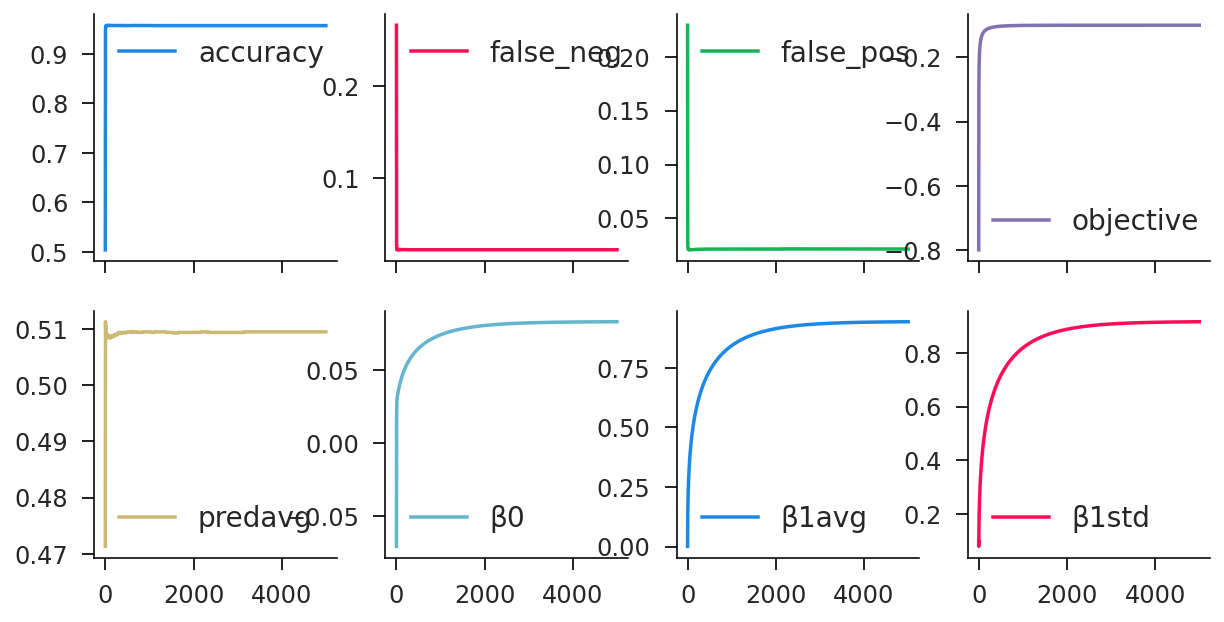

In [19]:
df.plot(subplots=True, layout=(2, 4), figsize=(10, 5));

In some settings, overfitting can be a big issue. Let's see how we do on some additional data that we didn't train on. Given the extremely simple nature of the model (two paramters) relative to the data complexity, I would expect minimal overfitting, and that is indeed what we see. The validation accuracy is nearly identical to the training accuracy.

In [20]:
# look at out of sample properties (validation accuracy)
val_space = np0.random.randn(N, dim)
val_rando = np0.random.logistic(size=N)
val_categ = β0t + val_space @ β1t + val_rando > 0
val_stats = logit_stats(coeff, val_space, val_categ)
pd.Series(val_stats)

β0             0.08343817
β1avg          0.94232845
β1std           0.9161499
accuracy            0.959
false_pos          0.0221
false_neg          0.0189
predavg            0.5094
objective    -0.097526215
dtype: object

### Non-linear data

Now let's do some non-linear, non-monotone data. Here we still use $100$ dimensions, but we classify the points based on whether they lie within a unit RMS neighborhood of the origin. With standard normal input data, this ensures that roughly half the points are in each category.

In [21]:
space = np0.random.randn(N, dim)
categ = np.sqrt(np.mean(space**2, axis=1)) < 1
print(np.mean(categ))

0.51629996


Running the same steps of estimation, visualization, and validation checking, we see that the convergence is much faster, but the ultimate predictive accuracy is only slightly better than random chance.

In [22]:
coeff, history = logit_estimate(space, categ, K=100, Δ=2.0)
df = pd.DataFrame(history)
df.iloc[-1]

accuracy     0.545200
false_neg    0.166000
false_pos    0.288800
objective   -0.688427
predavg      0.639100
β0           0.065691
β1avg        0.000680
β1std        0.018666
Name: 99, dtype: float32

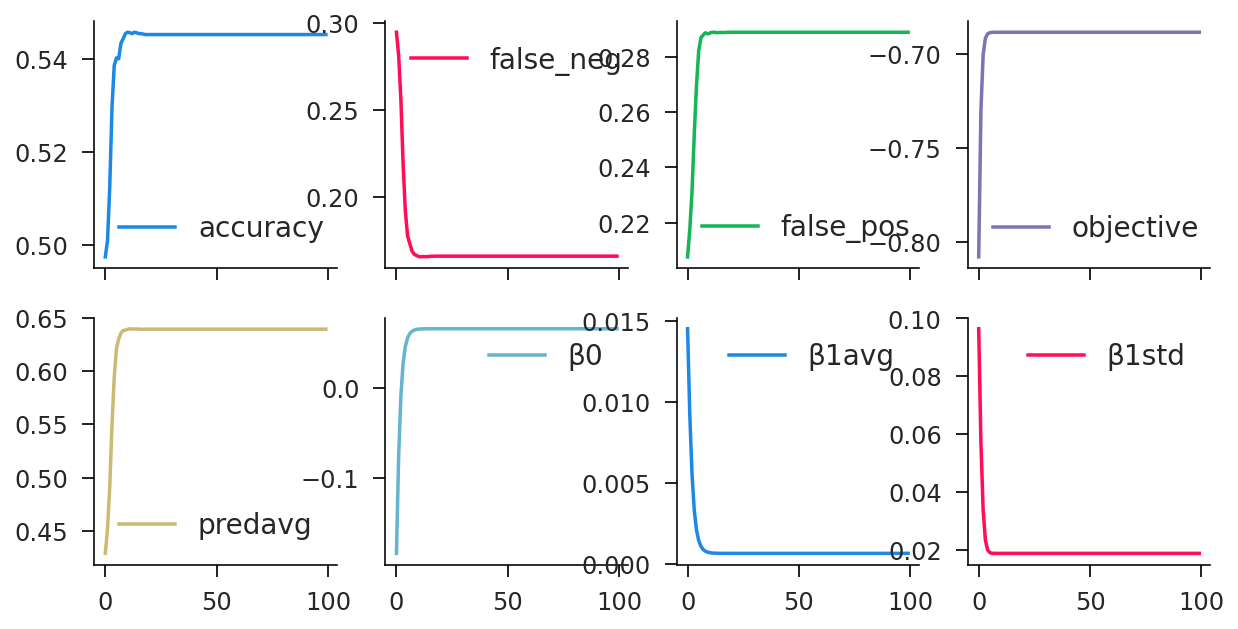

In [23]:
df.plot(subplots=True, layout=(2, 4), figsize=(10, 5));

In [24]:
# look at out of sample properties (validation accuracy)
val_space = np0.random.randn(N, dim)
val_categ = np.sqrt(np.sum(val_space**2, axis=1)) < np.sqrt(dim)
val_stats = logit_stats(coeff, val_space, val_categ)
pd.Series(val_stats)

β0            0.065691285
β1avg        0.0006799374
β1std         0.018665943
accuracy           0.5106
false_pos      0.31039998
false_neg      0.17899999
predavg            0.6458
objective      -0.6983996
dtype: object

So both the training validation accuracy are very low. And actually, that's not surprising. We're trying to classify a radially oriented category with a hyperplane. It's doomed to fail! So we need a more complex model.

## Neural Networks

Time for some neural networks! First, let's generate our data sample. Here I'm going with kind of midpoint between the linear and spherical case, and we're restricting ourselves to two dimensions so we can easily visualize things. The classification rule is some kind of hill function that obviously can't be captured with a single hyperplane.

In [25]:
Nt, Nv = 10000, 1000
hill_func = lambda dat: dat[:, 1] >= 2.5*dat[:, 0]*(1-dat[:, 0])
train_space = np0.random.rand(Nt, 2)
train_categ = hill_func(train_space)
valid_space = np0.random.rand(Nv, 2)
valid_categ = hill_func(valid_space)

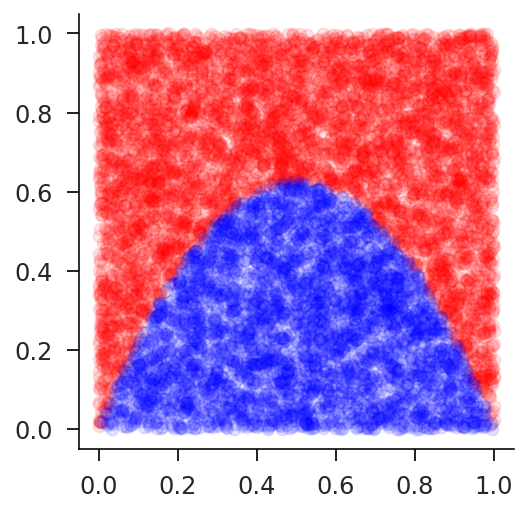

In [26]:
red_space = train_space[train_categ, :]
blue_space = train_space[~train_categ, :]
fig, ax = plt.subplots()
ax.scatter(red_space[:, 0], red_space[:, 1], alpha=0.1, color='red');
ax.scatter(blue_space[:, 0], blue_space[:, 1], alpha=0.1, color='blue');
plt.axis('square');

So we're going to need to basically chain two logistic regressions together into a two layer neural network. First we feed the data into the "hidden" layer (of arbitrary dimension), then the output of the hidden layer is fed to the output layer, which yields a single number. The steps below are roughly analogous to what we did for the logistic regression.

In [27]:
def neural_predict(c, x):
    W0, b0, W1, b1 = c['W0'], c['b0'], c['W1'], c['b1']
    hidden = jax.nn.sigmoid(x @ W0 + b0)
    output = hidden @ W1 + b1
    return output

In [28]:
def neural_objective(c, x, y):
    logits = neural_predict(c, x)
    like = binary_crossentropy(logits, y)
    return like.mean()
d_neural_objective = jax.grad(neural_objective)

In [29]:
def neural_stats(c, x, y):
    # generate predictions
    logits = neural_predict(c, x)
    predict = logits >= 0.0 # point prediction in {0,1}

    # fit assessment
    accuracy = np.mean(predict == y)
    false_pos = np.mean(predict & ~y)
    false_neg = np.mean(~predict & y)

    # return detached
    return {
        'accuracy': accuracy, 'false_pos': false_pos, 'false_neg': false_neg
    }

In [30]:
@partial(jax.jit, static_argnames='K')
def neural_regression(train_x, train_y, valid_x, valid_y, K=2000, Δ=2.0, hid=2):
    # generate coefficients of the appropriate shape
    c0 = {
        'W0': 2*np0.random.randn(2, hid),
        'b0': 2*np0.random.randn(hid),
        'W1': 2*np0.random.randn(hid),
        'b1': 2*np0.random.randn(),
    }

    # scan that baby
    def update(c, t):
        dc = d_neural_objective(c, train_x, train_y)
        c1 = update_coeff(c, dc, Δ)
        train_stats = neural_stats(c, train_x, train_y)
        valid_stats = neural_stats(c, valid_x, valid_y)
        return c1, (train_stats, valid_stats)

    return lax.scan(update, c0, np.arange(K))

Now for the training. One thing you'll notice is that it doesn't always succeed! Run it a couple of times until you get accuracy percentages in the high 90's. We're still using a very rudimentary gradient descent optimizer. We'll want to tech this up in the future, but I just want to show you how things can start to go wrong.

In [31]:
est, (train_hist, valid_hist) = neural_regression(train_space, train_categ, valid_space, valid_categ, Δ=2.0)
history = pd.concat([
    pd.DataFrame(train_hist).add_prefix('train_'),
    pd.DataFrame(valid_hist).add_prefix('valid_'),
], axis=1)
history.iloc[-1]

train_accuracy     0.8458
train_false_neg    0.1019
train_false_pos    0.0523
valid_accuracy     0.8410
valid_false_neg    0.0910
valid_false_pos    0.0680
Name: 1999, dtype: float32

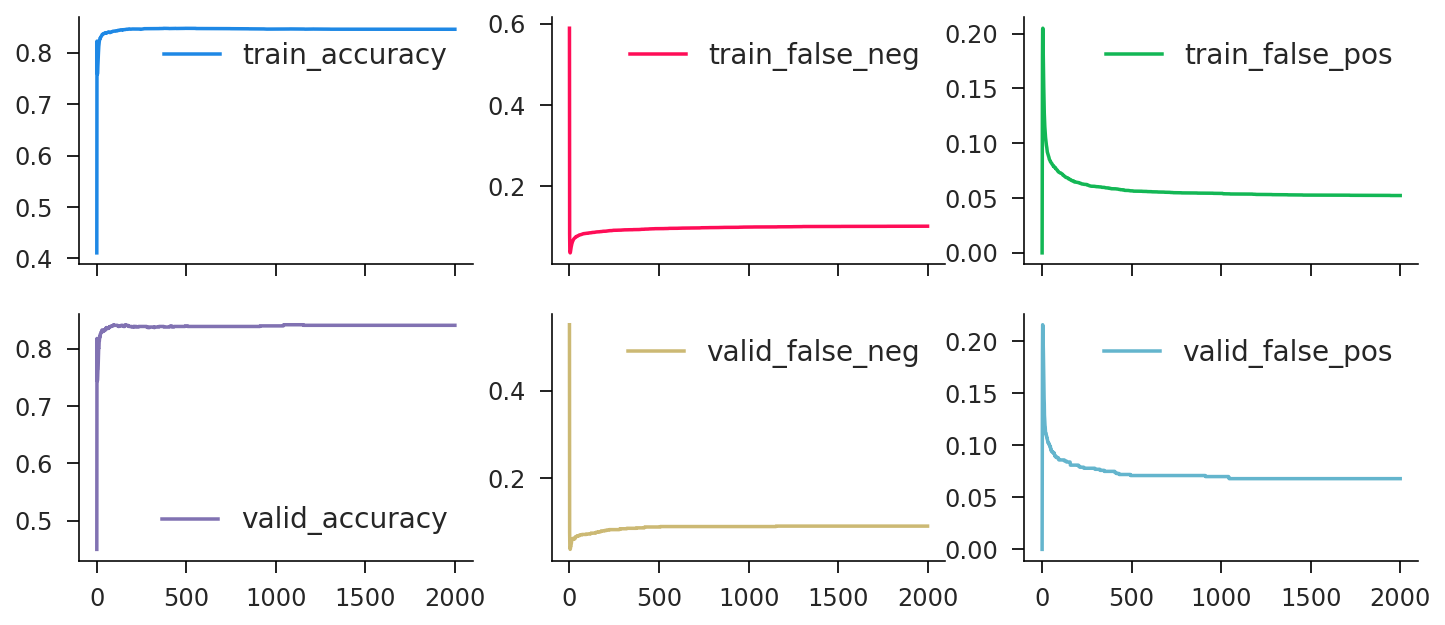

In [32]:
history.plot(subplots=True, layout=(2, 3), figsize=(12, 5));

Nonetheless, when it does work, we get good accuracy in the end. Let's try to visualize what exactly is going on. Below, I generate a scatter plot of the predicted values for a dense grid of input data. You can see it very closely resembles the true function, reflecting the high accuracy.

In [33]:
# useful for creating coordinate lists
cartesian_prod = lambda a, b: np.dstack(np.meshgrid(a, b)).reshape(-1, 2)
cartesian_prod(np.arange(3), np.arange(3, 6)).T

DeviceArray([[0, 1, 2, 0, 1, 2, 0, 1, 2],
             [3, 3, 3, 4, 4, 4, 5, 5, 5]], dtype=int32)

In [34]:
# construct uniform grid over (x, y)
M = 100
test_a = np.linspace(0, 1, M)
test_b = np.linspace(0, 1, M)
test_x = cartesian_prod(test_a, test_b)
test_logits = neural_predict(est, test_x)
test_pred = test_logits >= 0.0
test_red = test_x[test_pred, :]
test_blue = test_x[~test_pred, :]

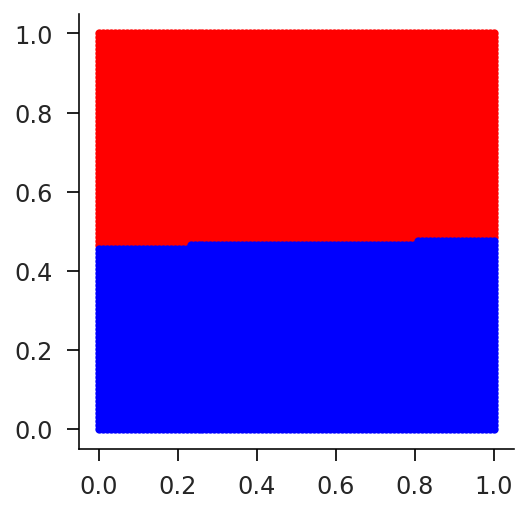

In [35]:
fig, ax = plt.subplots()
ax.scatter(test_red[:, 0], test_red[:, 1], color='red', s=10);
ax.scatter(test_blue[:, 0], test_blue[:, 1], color='blue', s=10);
plt.axis('square');

But we also have hidden layers, whose "activations" we can peer into. We need to be a little careful about how we do it, but below you can see how the non-linear shape is generated with the combination of two opposed hyperplanes. So the trained neural network is being kind of smart.

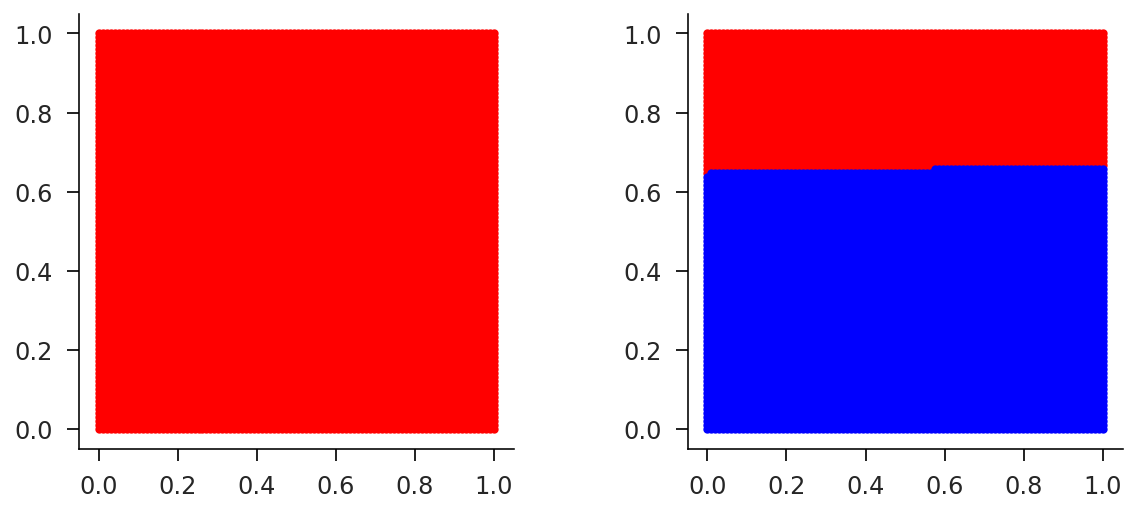

In [36]:
# get hidden layers
test_hidden = test_x @ est['W0'] + est['b0'] >= 0.0

# normalize by layer weight sign in final aggregation
layer_sign = est['W1'] < 0
layer_mask0 = layer_sign[0] ^ test_hidden[:, 0]
layer_mask1 = layer_sign[1] ^ test_hidden[:, 1]

# get hidden outputs
test0_red = test_x[layer_mask0, :]
test0_blue = test_x[~layer_mask0, :]
test1_red = test_x[layer_mask1, :]
test1_blue = test_x[~layer_mask1, :]

# plot both
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4))
ax0.scatter(test0_red[:, 0], test0_red[:, 1], color='red', s=10);
ax0.scatter(test0_blue[:, 0], test0_blue[:, 1], color='blue', s=10);
ax1.scatter(test1_red[:, 0], test1_red[:, 1], color='red', s=10);
ax1.scatter(test1_blue[:, 0], test1_blue[:, 1], color='blue', s=10);
ax0.axis('square');
ax1.axis('square');

## Getting Fancy: Optimizers

Okay, we've kind of been doing things by hand so far to get an idea of how things work. Now let's boost our productivity by using higher level tools built for neural networks. We may want to use more advanced optimizers than crude gradient descent. For this we can use the `optax` library, which is built on `jax`.

In [37]:
import optax
negate_tree = lambda t: jax.tree_map(lambda x: -x, t)

There are a few new concepts here. First, we create an optimizier `opt`, which in this case is `rmsprop`, a fairly common and effective one. Then we create a "state" which keeps track of things over time (for instance, a moving average of past gradients). We than use `opt.update` to update the state and generate increments for our parameters, which we apply with `apply_updates`, which is nearly identical to our `update_coeff` function. Note that people in machine learning *minimize* functions, so we need to negate the gradients we pass (which were generated with maximizing in mind).

In [38]:
@partial(jax.jit, static_argnames='K')
def neural_regression_optax(train_x, train_y, valid_x, valid_y, K=4000, Δ=0.01, hid=2):
    # generate coefficients of the appropriate shape
    c0 = {
        'W0': 2*np0.random.randn(2, hid),
        'b0': 2*np0.random.randn(hid),
        'W1': 2*np0.random.randn(hid),
        'b1': 2*np0.random.randn(),
    }
    
    # create and initialize an rmsprop optimizer
    opt = optax.rmsprop(learning_rate=Δ)
    state0 = opt.init(c0)

    # loop over iterations
    def update(cs, t):
        c, state = cs
        dc = negate_tree(d_neural_objective(c, train_x, train_y)) # optax minimizes!
        upd, state1 = opt.update(dc, state, c)
        c1 = optax.apply_updates(c, upd)
        train_stats = neural_stats(c, train_x, train_y)
        valid_stats = neural_stats(c, valid_x, valid_y)
        return (c1, state1), (train_stats, valid_stats)

    return lax.scan(update, (c0, state0), np.arange(K))

In [39]:
(est, _), (train_hist, valid_hist) = neural_regression_optax(train_space, train_categ, valid_space, valid_categ)
history = pd.concat([
    pd.DataFrame(train_hist).add_prefix('train_'),
    pd.DataFrame(valid_hist).add_prefix('valid_'),
], axis=1)
history.iloc[-1]

train_accuracy     0.9847
train_false_neg    0.0077
train_false_pos    0.0076
valid_accuracy     0.9790
valid_false_neg    0.0090
valid_false_pos    0.0120
Name: 3999, dtype: float32

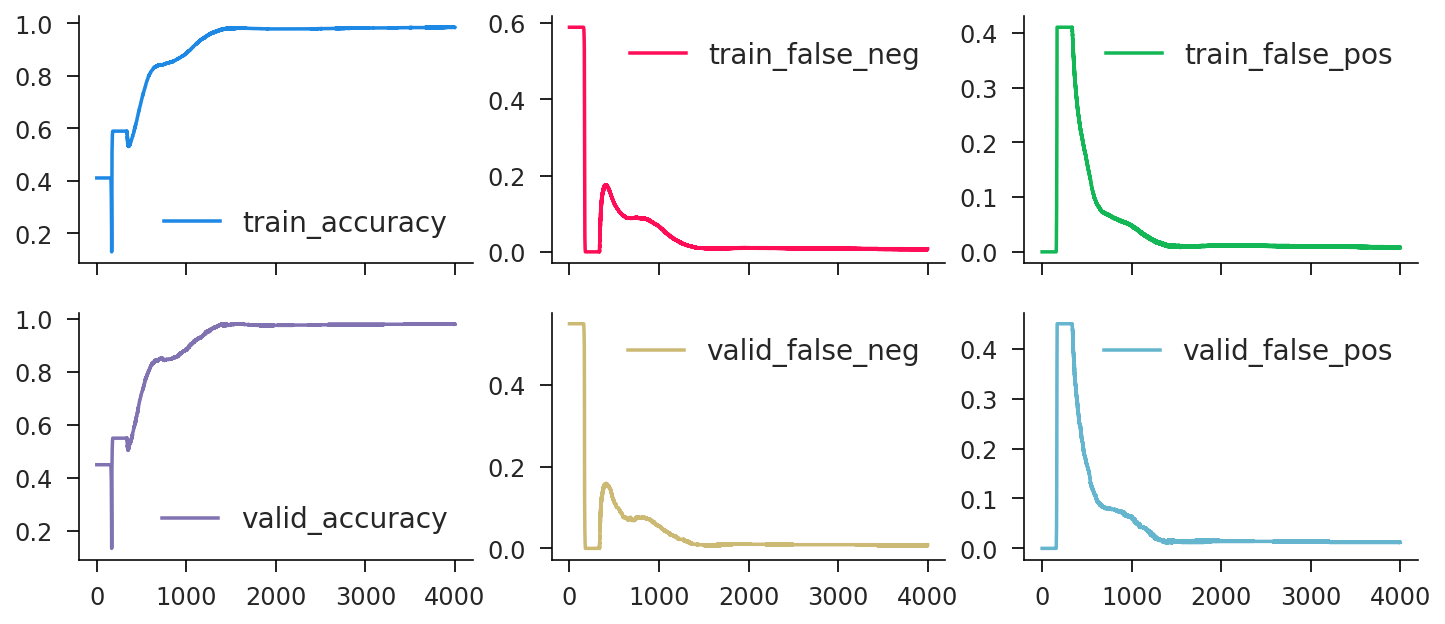

In [40]:
history.plot(subplots=True, layout=(2, 3), figsize=(12, 5));

It works much better now! Note that different optimizers work better or worse for different types of problems. In this case `rmsprop` works quite well, while `adam` doesn't seem to reliably work.

## Getting Fancy: Modules

Creating modular and reusable blocks that we assemble into complex neural networks is the name of the game in deep learning. In the `jax` world, there is a library called `flax` that does a lot of the heavy lifting here. There are actually quite a few libraries that implement the "Module" concept in the `jax` ecosystem. And this idea actually stems originally from `pytorch` and `keras`, which builds on top of `tensorflow`.

In [41]:
import flax.linen as nn

In [42]:
# this outputs 2 logits corresponding to 0 and 1
class Neural(nn.Module):
    hid: int

    def setup(self):
        self.hidden = nn.Dense(self.hid)
        self.output = nn.Dense(2)

    def __call__(self, x):
        x = self.hidden(x)
        x = nn.sigmoid(x)
        x = self.output(x)
        return x

In [43]:
def fancy_stats(logits, target):
    predict = logits[:, 1] >= logits[:, 0]
    return {
        'accuracy': np.mean(predict == target),
        'false_pos': np.mean(predict & ~target),
        'false_neg': np.mean(~predict & target),
        'pred_val': np.mean(predict),
    }

In [44]:
def neural_regression_flax(train_x, train_y, valid_x, valid_y, K=4000, Δ=0.01, hid=2):
    # convert boolean to 2-dim one hot
    train_c = jax.nn.one_hot(train_y.astype(int), 2)
    valid_c = jax.nn.one_hot(valid_y.astype(int), 2)

    # create model and initialize params randomly
    model = Neural(hid)
    params0 = model.init(jax.random.PRNGKey(42), train_x)

    # define the objective and its gradient
    def objective(p):
        logits = model.apply(p, train_x)
        like = optax.softmax_cross_entropy(logits, train_c)
        return like.mean()
    d_objective = jax.grad(objective)

    # create and initialize an rmsprop optimizer
    opt = optax.rmsprop(learning_rate=Δ)
    state0 = opt.init(params0)

    # define the update function
    @jax.jit
    def update(s, t):
        c, state = s
        dc = d_objective(c)

        upd, state1 = opt.update(dc, state, c)
        c1 = optax.apply_updates(c, upd)

        train_logits = model.apply(c, train_x)
        valid_logits = model.apply(c, valid_x)
        train_stats = fancy_stats(train_logits, train_y)
        valid_stats = fancy_stats(valid_logits, valid_y)

        return (c1, state1), (train_stats, valid_stats)

    res = lax.scan(update, (params0, state0), np.arange(K))
    return model, *res

In [45]:
model, (est, _), (train_hist, valid_hist) = neural_regression_flax(train_space, train_categ, valid_space, valid_categ)
history = pd.concat([
    pd.DataFrame(train_hist).add_prefix('train_'),
    pd.DataFrame(valid_hist).add_prefix('valid_'),
], axis=1)

history.iloc[-1]

train_accuracy     0.9904
train_false_neg    0.0049
train_false_pos    0.0047
train_pred_val     0.5890
valid_accuracy     0.9880
valid_false_neg    0.0060
valid_false_pos    0.0060
valid_pred_val     0.5500
Name: 3999, dtype: float32

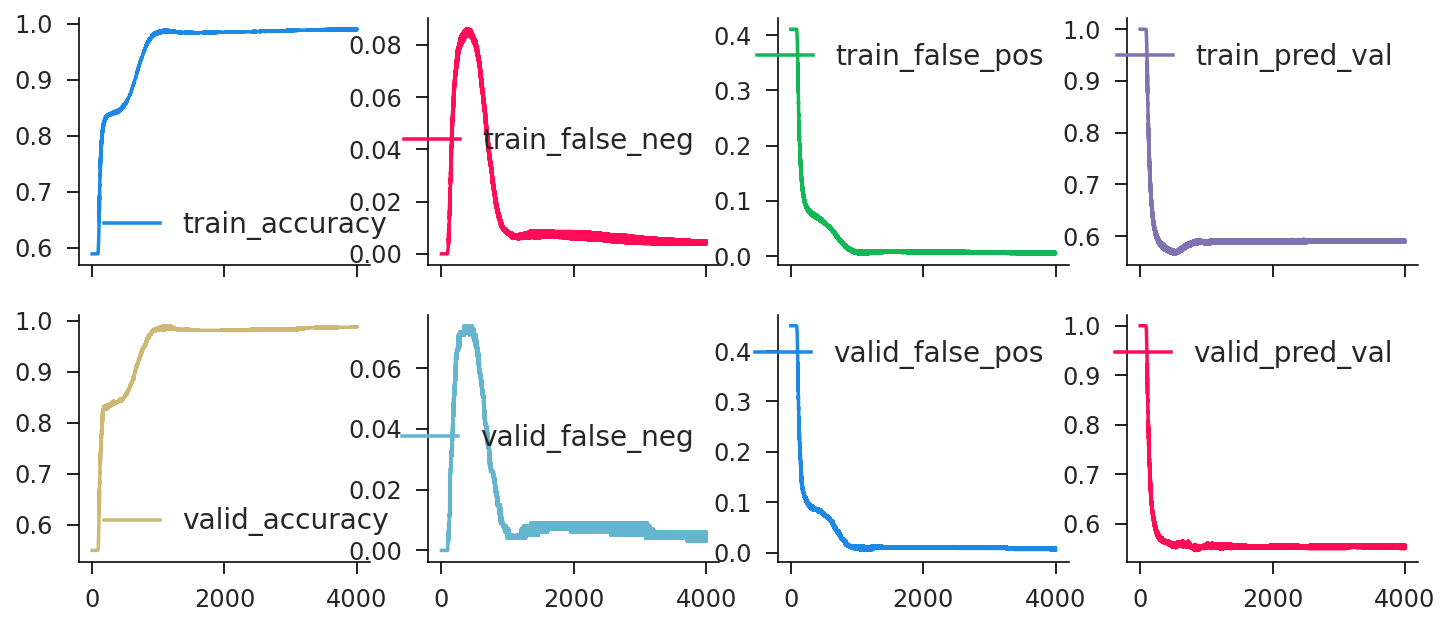

In [46]:
history.plot(subplots=True, layout=(2, 4), figsize=(12, 5));